In [2]:
import pandas as pd
from pandas.plotting import scatter_matrix
import sqlite3

In [3]:
data = sqlite3.connect("../data/checking-logs.sqlite")

In [4]:
sql_request1 = """
SELECT uid, COUNT(*) AS pageviews FROM pageviews
WHERE uid LIKE "user_%"
GROUP BY uid
"""

In [5]:
dataframe_view = pd.read_sql(sql_request1, data)

dataframe_view

,uid,pageviews
0,user_1,28
1,user_10,89
2,user_14,143
3,user_17,47
4,user_18,3
5,user_19,16
6,user_21,10
7,user_25,179
8,user_28,149
9,user_3,317


In [6]:
sql_request2 = """
SELECT uid, COUNT(*) AS commits_num FROM checker
WHERE uid LIKE "user_%" AND labname != "project1"
GROUP BY uid
"""

In [7]:
dataframe_commits = pd.read_sql(sql_request2, data)

dataframe_commits

,uid,commits_num
0,user_0,3
1,user_1,62
2,user_10,20
3,user_11,7
4,user_12,86
5,user_13,52
6,user_14,61
7,user_15,23
8,user_16,41
9,user_17,51


In [8]:
sql_request01 = """
    CREATE TABLE IF NOT EXISTS test AS
    SELECT checker.uid,
           checker.labname,
           checker.timestamp AS first_commit_ts,
           pageviews.datetime AS first_view_ts
    FROM checker
           LEFT JOIN pageviews ON checker.uid = pageviews.uid
    WHERE checker.uid LIKE "user_%"
           AND numTrials = 1
           AND status = "ready"
           AND labname IN ('laba04', 'laba04s', 'laba05', 'laba06', 'laba06s', 'project1')
           AND pageviews.datetime = (SELECT MIN(pageviews.datetime) FROM pageviews
                                                                    WHERE uid = checker.uid);
"""

data.execute(sql_request01)

In [ ]:
sql_request02 = """
SELECT uid, cast((julianday(test.first_commit_ts) - julianday(datetime(deadlines.deadlines, 'unixepoch')))
        * 24 AS integer) AS avg_diff
FROM test
LEFT JOIN deadlines ON deadlines.labs = test.labname
WHERE test.labname != 'project1'
"""

delta = pd.read_sql(sql_request02, data)

delta

,uid,avg_diff
0,user_30,-202
1,user_30,-201
2,user_14,-200
3,user_14,-193
4,user_19,-148
5,user_25,-148
6,user_21,-126
7,user_21,-99
8,user_28,-98
9,user_17,-81


In [12]:
delta = delta.groupby("uid").mean("delta")

In [13]:
delta

,avg_diff
uid,
user_1,-64.400000
user_10,-74.800000
user_14,-159.000000
user_17,-61.600000
user_18,-5.666667
user_19,-98.750000
user_21,-95.500000
user_25,-92.600000
user_28,-86.400000


In [14]:
pivot = pd.merge(dataframe_commits, dataframe_view, on = "uid", how = "inner")

pivot = pd.merge(pivot, delta, on = "uid", how = "inner")

In [15]:
pivot

,uid,commits_num,pageviews,avg_diff
0,user_1,62,28,-64.400000
1,user_10,20,89,-74.800000
2,user_14,61,143,-159.000000
3,user_17,51,47,-61.600000
4,user_18,5,3,-5.666667
5,user_19,118,16,-98.750000
6,user_21,65,10,-95.500000
7,user_25,79,179,-92.600000
8,user_28,60,149,-86.400000
9,user_3,18,317,-105.400000


array([[<Axes: xlabel='avg_diff', ylabel='avg_diff'>,
        <Axes: xlabel='pageviews', ylabel='avg_diff'>,
        <Axes: xlabel='commits_num', ylabel='avg_diff'>],
       [<Axes: xlabel='avg_diff', ylabel='pageviews'>,
        <Axes: xlabel='pageviews', ylabel='pageviews'>,
        <Axes: xlabel='commits_num', ylabel='pageviews'>],
       [<Axes: xlabel='avg_diff', ylabel='commits_num'>,
        <Axes: xlabel='pageviews', ylabel='commits_num'>,
        <Axes: xlabel='commits_num', ylabel='commits_num'>]], dtype=object)

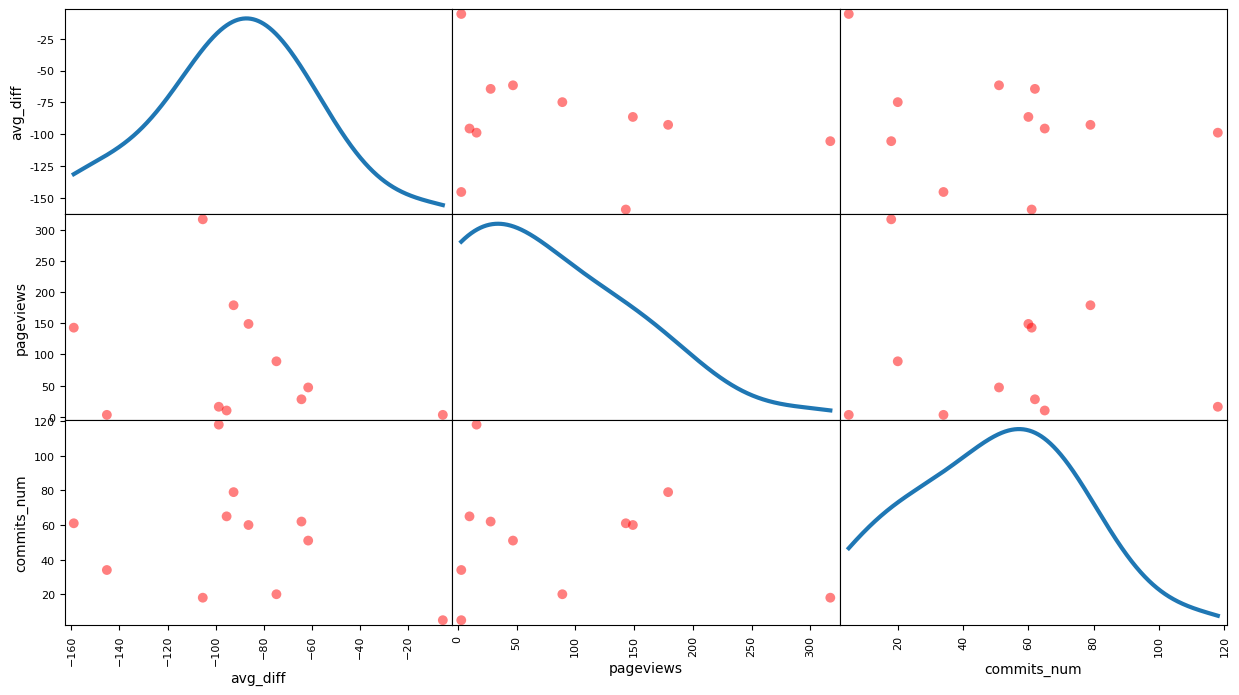

In [16]:
date = pivot[["avg_diff", "pageviews", "commits_num"]]

scatter_matrix(date, figsize=(15, 8), diagonal="kde", s = 200, color = "r", density_kwds=dict(linewidth = 3))

## Можно ли сказать, что если у пользователя мало просмотров страниц, то, скорее всего, у него мало коммитов?

- Нет

## Можно ли сказать, что если у пользователя мало просмотров страниц, то, скорее всего, у него небольшая средняя разница между первым коммитом и дедлайном лабораторной?

- Нет

## Можно ли сказать, что много пользователей с малым количеством коммитов и немного — с большим количеством?

- Да

## Можно ли сказать, что много пользователей с небольшой средней разницей и немного — с большой средней разницей?

- Нет

In [17]:
data.close()